# Assessing correctness of zod_frames_index

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


df = pd.read_parquet("~/multimodal-MoE/outputs/index/zod256_frames.parquet")

df.shape, df.columns.tolist()


((99999, 18),
 ['frame_id',
  'time',
  'image_path',
  'scraped_weather',
  'time_of_day',
  'solar_angle_elevation',
  'country_code',
  'road_type',
  'road_condition',
  'ped_count_clear',
  'ped_count_unclear',
  'ped_occ_none',
  'ped_occ_light',
  'ped_occ_medium',
  'ped_occ_heavy',
  'ped_occ_veryheavy',
  'ped_occ_unknown',
  'ped_bin_4'])

In [28]:
""" Note that for bin_4:
    - 0: no pedestrians
    - 1: 1-5 pedestrians
    - 2: 6-15 pedestrians
    - 3: >15 pedestrians
    - we can also define pedestrian presence 0 if bin_4 == 0, else 1. 
    """

#define pedestrian presence 0 if bin_4 == 0, else 1
#This allows us to train a model to predict pedestrian presence as well in case binning is problematic
df["ped_presence"] = df["ped_bin_4"].apply(lambda x: 0 if x == 0 else 1)

df.head()

# We would like to update the parquet file to include the new column
# First, we need to read the existing parquet file
# Save the updated dataframe with the new column back to the parquet file
df.to_parquet("~/multimodal-MoE/outputs/index/zod256_frames.parquet", index=False)




In [30]:
#Now we pull from parquete file to check the new column
df1 = pd.read_parquet("~/multimodal-MoE/outputs/index/zod256_frames.parquet")
df1.head()



,frame_id,time,image_path,scraped_weather,time_of_day,solar_angle_elevation,country_code,road_type,road_condition,ped_count_clear,ped_count_unclear,ped_occ_none,ped_occ_light,ped_occ_medium,ped_occ_heavy,ped_occ_veryheavy,ped_occ_unknown,ped_bin_4,ped_presence
0,050000,2020-05-05T05:01:50.446218Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,partly-cloudy-day,day,16.170558,SE,city,normal,1,0,1,0,0,0,0,0,1,1
1,050001,2020-05-28T15:54:23.333153Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,cloudy,day,27.834328,SE,city,normal,1,0,0,0,0,1,0,0,1,1
2,050002,2020-12-01T12:06:14.004010Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,rain,day,15.790678,DE,city,wet,1,0,1,0,0,0,0,0,1,1
3,050003,2020-04-14T07:24:35.996646Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,clear-day,day,28.634695,DE,city,normal,1,0,0,0,0,0,1,0,1,1
4,050004,2021-04-15T10:16:19.993984Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,rain,day,47.714986,PL,city,wet,5,3,0,3,0,2,0,3,1,1


In [15]:
#Label distribution (excluding unclear pedestrians from the count)
df["ped_bin_4"].value_counts().sort_index()


ped_bin_4
0    42421
1    38395
2    15695
3     3488
Name: count, dtype: int64

In [ ]:

df["ped_count_clear"].describe(), df["ped_count_unclear"].describe()
# we see below that there are far more clear pedestrians on average (3.18) than unclear pedestrians (0.41)


(count    99999.000000
 mean         3.185832
 std          5.378451
 min          0.000000
 25%          0.000000
 50%          1.000000
 75%          4.000000
 max        127.000000
 Name: ped_count_clear, dtype: float64,
 count    99999.000000
 mean         0.405954
 std          1.339227
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max         84.000000
 Name: ped_count_unclear, dtype: float64)

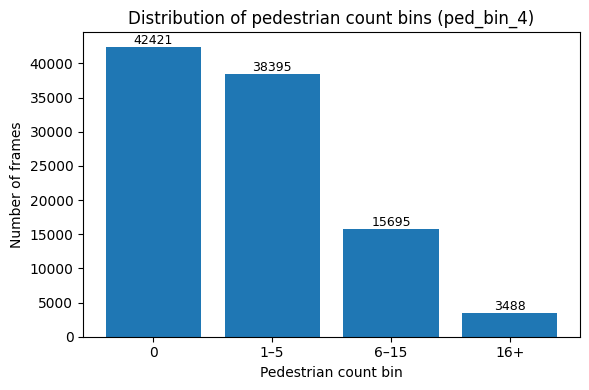

In [ ]:
#HISTOGRAM OF PEDESTRIAN COUNT BINS
counts = df["ped_bin_4"].value_counts().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(range(4), counts.values)

plt.xlabel("Pedestrian count bin")
plt.ylabel("Number of frames")
plt.title("Distribution of pedestrian count bins (ped_bin_4)")
plt.xticks(range(4), ["0", "1–5", "6–15", "16+"])

for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [19]:
#Checking for missing values in the metadata
df[["scraped_weather","time_of_day","solar_angle_elevation","road_type","road_condition"]].isna().mean().sort_values(ascending=False)



scraped_weather          0.0
time_of_day              0.0
solar_angle_elevation    0.0
road_type                0.0
road_condition           0.0
dtype: float64

In [20]:
sample = df.sample(20, random_state=0)
missing = [p for p in sample["image_path"] if not Path(p).exists()]
len(missing), missing[:3]


(0, [])

In [21]:
occ_sum = df[["ped_occ_none","ped_occ_light","ped_occ_medium","ped_occ_heavy","ped_occ_veryheavy","ped_occ_unknown"]].sum(axis=1)
bad = (occ_sum > (df["ped_count_clear"] + df["ped_count_unclear"])).sum()
bad


np.int64(0)

In [22]:
# Bins by time of day
pd.crosstab(df["time_of_day"], df["ped_bin_4"])


ped_bin_4,0,1,2,3
time_of_day,,,,
day,26082,33172,14774,3318
night,14363,4041,521,81
twilight,1976,1182,400,89


In [25]:
#Bins by weather condition
pd.crosstab(df["scraped_weather"], df["ped_bin_4"])

ped_bin_4,0,1,2,3
scraped_weather,,,,
clear-day,5818,7283,2740,600
clear-night,2959,840,171,29
cloudy,7269,7139,3670,913
fog,1415,552,131,19
partly-cloudy-day,8276,13294,6178,1405
partly-cloudy-night,7451,3003,563,107
rain,7843,5525,1985,362
snow,1036,686,220,30
wind,354,73,37,23


In [26]:
#Bins by road type
pd.crosstab(df["road_type"], df["ped_bin_4"])

ped_bin_4,0,1,2,3
road_type,,,,
arterial-rural,9156,727,38,4
arterial-urban,11123,8940,3029,710
city,7311,27444,12537,2769
highway,10861,191,8,1
smaller-rural,3970,1093,83,4


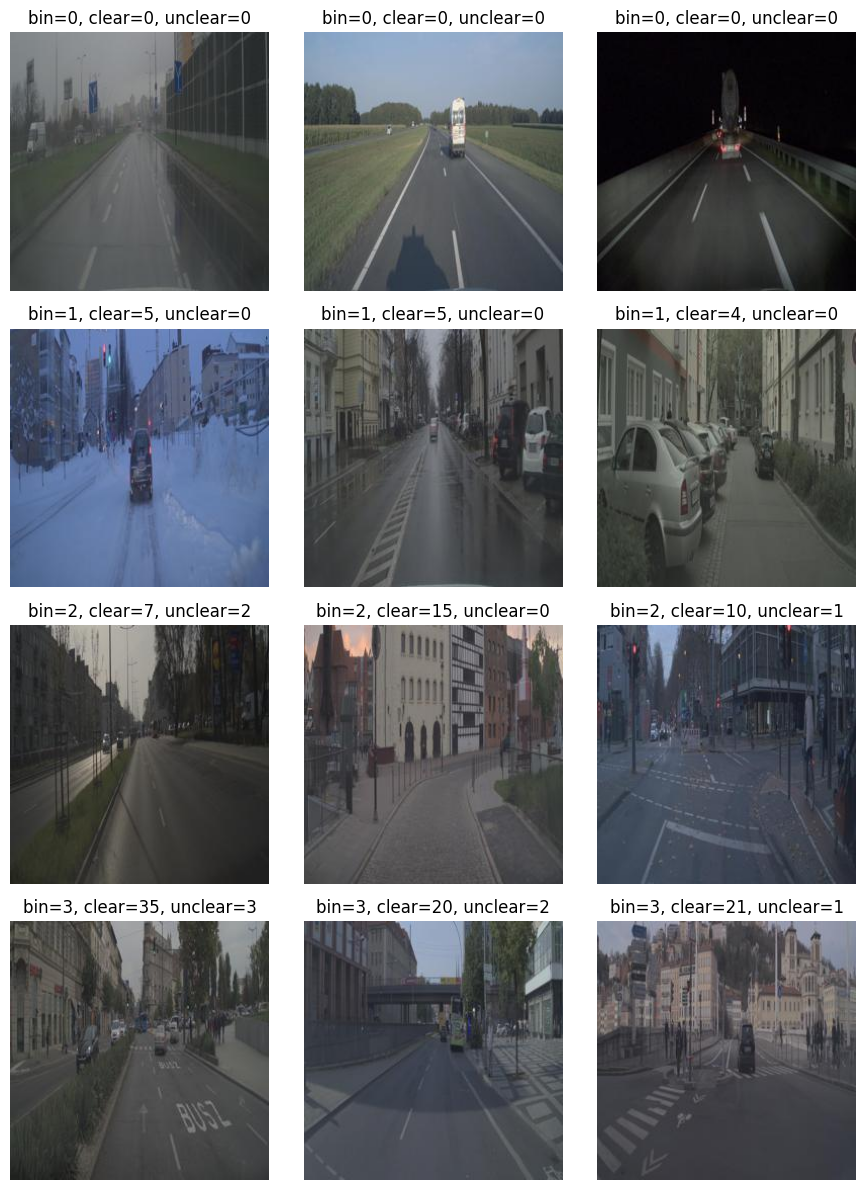

In [27]:
from PIL import Image

bins = [0,1,2,3]
fig, axes = plt.subplots(4, 3, figsize=(9, 12))

for i, b in enumerate(bins):
    sub = df[df["ped_bin_4"] == b].sample(3, random_state=1)
    for j, (_, r) in enumerate(sub.iterrows()):
        img = Image.open(r["image_path"]).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"bin={b}, clear={r['ped_count_clear']}, unclear={r['ped_count_unclear']}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()
